In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

## Time evolution of spin chain using TEBD

Let's simulate the time evolution of the Néel ordered state
$$
    |\psi\rangle = |\downarrow\uparrow\downarrow\uparrow\cdots\rangle
$$
under the Hamiltonian
$$
    \mathcal{H} = -J \sum_{i=1}^{N-1} \mathbf{S}_i \cdot \mathbf{S}_{i+1}.
$$

#### Building blocks
To use TEBD, we'll first need to define some MPS building blocks. Specifically:
* Our initial state,
* The two-site Hamiltonian and time evolution operator $U$,
* The spin projection operator $S_z$.

In defining our matrix product states, we'll stick to the following labeling conventions: the first label will correspond to physical indices, followed by the virtual indices. Further clarification is given in the comments.

In [2]:
def initial_state(N):
    """ Returns the full specification of an MPS with perfect Néel order """
    d = 2     # Dimension size of physical index
    B = []    # On-site component of MPS
    s = []    # Diagonal matrix containing singular values

    for i in range(N):
        Bn = np.zeros( [d, 1, 1], dtype = complex )
                # We have d dimensions in the physical index, and one dimension on the virtual indices
        
        Bn[ (i + 1) % 2, 0, 0 ] = 1
                # Configure initial state with perfect Néel order
        
        B.append( Bn )
        s.append( np.ones(1) )
                # Extend B and s, the latter by adding a trivial 1
    
    s.append( np.ones(1) )
            # Add an extra S matrix for putting MPS into canonical form
    
    return B, s

Next we need to specify the matrices and operators that work on our bonds. In our TEBD treatment of the Heisenberg model this will simply be an array of two-site operators.

In [109]:
# Start by defining all the Pauli spin matrices
sx = np.array( [[0, 1], [1, 0]] )
sy = np.array( [[0, -1j], [1j, 0]] )
sz = np.array( [[1, 0], [0, -1]] )

def heisenberg_bonds(J, N, delta_t):
    """
    Returns the Hamiltonian and time-evolution block in matrix-product form.
    J is the strength of the superexchange,
    delta_t is the size of the time step
    """
    d = 2         # Dimension size of the physical index
    H_bond = []   # Block giving Hamiltonian operator of a pair of sites
    U_bond = []   # Block giving time evolution operator of pair of sites
    
    for i in range(N - 1):
        H = -J * ( np.kron(sx, sx) + np.kron(sy, sy) + np.kron(sz, sz) )
                # For two sites the Hamiltonian is simply a Kronecker product of the single-site operators
            
        H_bond.append( np.reshape( H, (d, d, d, d) ) )
                # Add to array, reshape into tensor form: two (physical) upper indices and two (physical) lower ones
        
        U_bond.append( np.reshape( expm(-1j * delta_t * H), (d, d, d, d) ) )
                # Calculate time evolution operator, and reshape in the same way
    
    return H_bond, U_bond

In [122]:
def Sz(B, s, i):
    """
    Calculate the expectation value of Sz on site i, given an MPS defined by B and s
    """
    ss = np.tensordot( np.diag(s[i]), np.diag(s[i]), axes = (0, 0) )
    BSz = np.tensordot( sz, B[i], axes = (1, 0) )
        # physical, left virtual, right virtual
    BSzB = np.tensordot( BSz, np.conj( B[i] ), axes = (0, 0) )
        # left virtual top, right virtual top, left virtual bottom, right virtual bottom
    ssBSzB = np.tensordot( ss, BSzB, axes = ([0, 1], [0, 2]))
        # right virtual top, right virtual bottom
    
    return np.real(np.trace( ssBSzB ))

#### Sweeping through one timestep $\delta t$
Havind defined the initial state and the Hamiltonian (plus time evolution operator), we can define a function that will take in our MPS (consisting of `B` and `s`), and propagate it with one time step $\delta t$. Crucially, for large system sizes we limit the number of singular values that can sit in between two sites. This is sometimes referred to as the 'bond dimension,' and we'll not allow it to exceed `chi`.

For bookkeeping purposes, the singular value matrix to the right of any on-site tensor is left contracted. This saves us a few lines of code. See [these notes by Frank Pollmann](http://quantumtensor.pks.mpg.de/wp-content/uploads/2016/06/notes_1.pdf) for some more details on the philosophy behind this implementation.

In [121]:
def sweep(B, s, U_bond, chi):
    """
    Given some matrix product state specified by B and s, advance it one step in time, as described by the
    Trotterized time evolution operators U_bond. We allow for a maximal bond dimension of chi. We sweep from
    left to right. Adapted from Frank Pollmann's sweep algorithm, also see Pollmann (2016).
    """
    N = len(B)
    d = B[0].shape[0]
    for k in [0, 1]:
        # First we loop over all the even bonds, then over the odd ones
        
        for i_b in range(k, N - 1, 2):
            chia = B[i_b].shape[1]
            chib = B[i_b + 1].shape[2]
                # Get dimensions of virtual bonds extending to the left and right of the system
            
            """ Start by contracting the MPS at the right place, and add in time evolution operator """
            theta = np.tensordot( B[i_b], np.diag(s[i_b]), axes = (1, 1) )
            theta = np.transpose( theta, (0, 2, 1) )
                    # Contract tensor Bi and principal value matrix si that sits to its left, result:
                        # physical, left virtual, right virtual
            
            theta = np.tensordot( theta, B[i_b + 1], axes = (2, 1) )
                    # Contract with tensor Bi+1, result:
                        # left physical, left virtual, right physical, right virtual
                
            theta = np.tensordot( U_bond[i_b], theta, axes = ([2, 3], [0, 2]) )
                    # Contract with time evolution operator Ui, result:
                        # left physical, right physical, left virtual, right virtual
                    
            theta = np.transpose( theta, (0, 2, 1, 3) )
                    # Swap indices around such that the LHS and RHS are grouped.
            
            theta = np.reshape( theta, (d * chia, d * chib) )
                    # Reshape into matrix such that the rows and columns correspond to the LHS and RHS of the system
            
            
            """ Do the SVD """
            X, Y, Zt = np.linalg.svd( theta, full_matrices = 0 )
                    # Do the SVD
            
            """ Remove basis states until at most chi significant ones remain """
            chi_act = np.min( [ np.sum(Y > 10**-10), chi ] )
            selected = np.argsort(Y)[::-1][:chi_act]
                    # Find the indices of the chi_act largest singular values
                
            Y = Y[selected]
            X = X[:, selected]
            Zt = Zt[selected, :]
                    # Select only the chi_act largest singular values and left- and right-singular vectors
            
            """ Unpack SVD a little more so that we get everything in the right shape. """
            s[i_b + 1] = Y / np.sqrt( sum( Y**2 ) )
                    # Save new singular values (normalized)
            
            X = np.reshape( X, ( d, chia, len(Y) ) )
                    # physical, left virtual, right virtual
                
            X = np.tensordot( X, np.diag( 1/s[i_b] ), axes = (1, 1) ) # phys, virt right, virt left
            X = np.tensordot( X, np.diag( s[i_b + 1] ), axes = (1, 0) ) # phys, virt left, virt right
                    # Divide out the old singular value matrix, which we contracted before, and contract with the new one:
                        # physical, left virtual, right virtual
            B[i_b] = X
                
            Zt = np.reshape( Zt, (len(Y), d, chib) )
            Zt = np.transpose( Zt, (1, 0, 2) )
                    # The matrix that comes out of the SVD has dimensions chi x (d * chib), we unpack and reorder this.
                
            B[i_b + 1] = Zt

### Short chain, which we can compare to exact diagonalization

In [126]:
dt = 0.01
J = 1.
N = 10
chi = 30
B, s = initial_state(N)
H_bond, U_bond = heisenberg_bonds(J, N, dt)

tmax = 10
tsteps = round( tmax/dt )
timeax = np.arange(0, tmax, dt)

sz_t = np.zeros( tsteps )
neel_t = np.zeros( tsteps )

for i in range(tsteps):
    sz_t[i] = Sz(B, s, 0)
    neel_t[i] = sum([(-1)**(k+1) * Sz(B, s, k) for k in range(N)])/N
    sweep(B, s, U_bond, chi)    

### Displaying the results
Load data from exact diagonalization:

In [131]:
ed_dat = np.loadtxt("ed-results.csv", delimiter = ",")

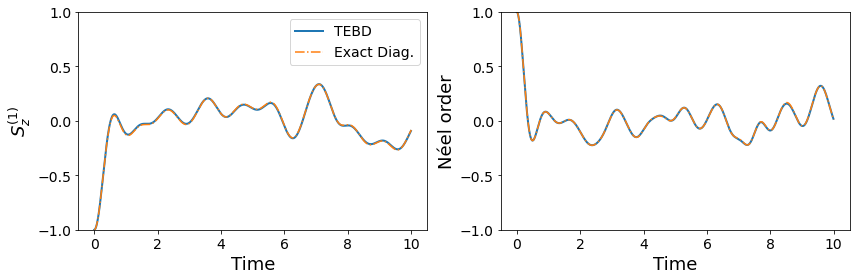

In [132]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(timeax, sz_t, lw = 2, label = "TEBD")
ax[0].plot(ed_dat[:, 0], ed_dat[:, 1], ls = "-.", label = "Exact Diag.")
ax[1].plot(timeax, neel_t, lw = 2, label = "TEBD")
ax[1].plot(ed_dat[:, 0], ed_dat[:, 2], ls = "-.", label = "Exact Diag.")

ax[0].set_ylabel(r"$S_z^{(1)}$", fontsize = 18)
ax[0].set_xlabel("Time", fontsize = 18)
ax[1].set_ylabel("Néel order", fontsize = 18)
ax[1].set_xlabel("Time", fontsize = 18)
ax[0].set_ylim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[0].tick_params(labelsize = 14)
ax[1].tick_params(labelsize = 14)
ax[0].legend(fontsize = 14)
plt.tight_layout()

### Extend chain, $N = 100$

In [133]:
dt = 0.01
J = 1.
N = 100
chi = 30
B, s = initial_state(N)
H_bond, U_bond = heisenberg_bonds(J, N, dt)

tmax = 10
tsteps = round( tmax/dt )
timeax = np.arange(0, tmax, dt)

sz_t = np.zeros( tsteps )
neel_t = np.zeros( tsteps )

for i in range(tsteps):
    sz_t[i] = Sz(B, s, 0)
    neel_t[i] = sum([(-1)**(k+1) * Sz(B, s, k) for k in range(N)])/N
    sweep(B, s, U_bond, chi)    

##### Displaying the results
Load data from exact diagonalization:

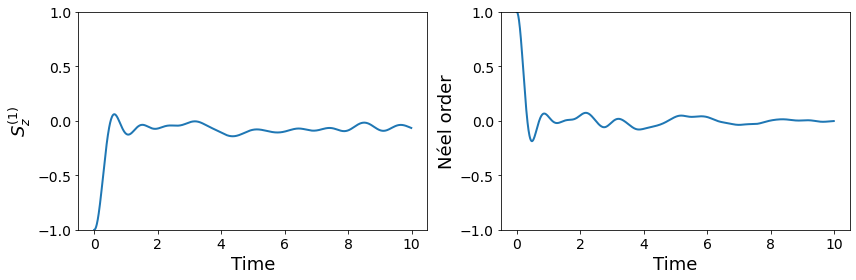

In [134]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(timeax, sz_t, lw = 2)
ax[1].plot(timeax, neel_t, lw = 2)

ax[0].set_ylabel(r"$S_z^{(1)}$", fontsize = 18)
ax[0].set_xlabel("Time", fontsize = 18)
ax[1].set_ylabel("Néel order", fontsize = 18)
ax[1].set_xlabel("Time", fontsize = 18)
ax[0].set_ylim([-1, 1])
ax[1].set_ylim([-1, 1])
ax[0].tick_params(labelsize = 14)
ax[1].tick_params(labelsize = 14)
plt.tight_layout()